In [24]:
from pystac_client import Client
from shapely.geometry import Point, Polygon, LineString
import rioxarray
import pystac
from pyproj import CRS
import rasterio
import dask

## Get Raster Data

In [2]:
api_url = "https://earth-search.aws.element84.com/v1"

client = Client.open(api_url)

In [3]:
collection = "sentinel-2-l2a"  # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)

In [4]:
point = Point(-122.54139915601945, 38.020000922925874)

In [5]:
search = client.search(
    collections=[collection],
    intersects=point,
    max_items=10,
    datetime="2023-04-01/2023-04-30",
    query=["eo:cloud_cover<15"]
)
print(search.matched())

4


In [6]:
items = search.item_collection()

In [7]:
assets = items[-1].assets  # last item's assets
visual_href = assets["visual"].href  # true color image

In order to save on compute time, we will work with overviews which are lower resolution than the original. "Overviews are often computed using powers of 2 as down-sampling (or zoom) factors. So, typically, the first level overview (index 0) corresponds to a zoom factor of 2, the second level overview (index 1) corresponds to a zoom factor of 4, and so on. Here, we open the third level overview (zoom factor 8) and check that the resolution is about 80 m"

In [8]:
visual = rioxarray.open_rasterio(visual_href, overview_level=2)
print(visual.rio.resolution())

(79.97086671522214, -79.97086671522214)


### Load data into memory

In [9]:
visual = visual.load()

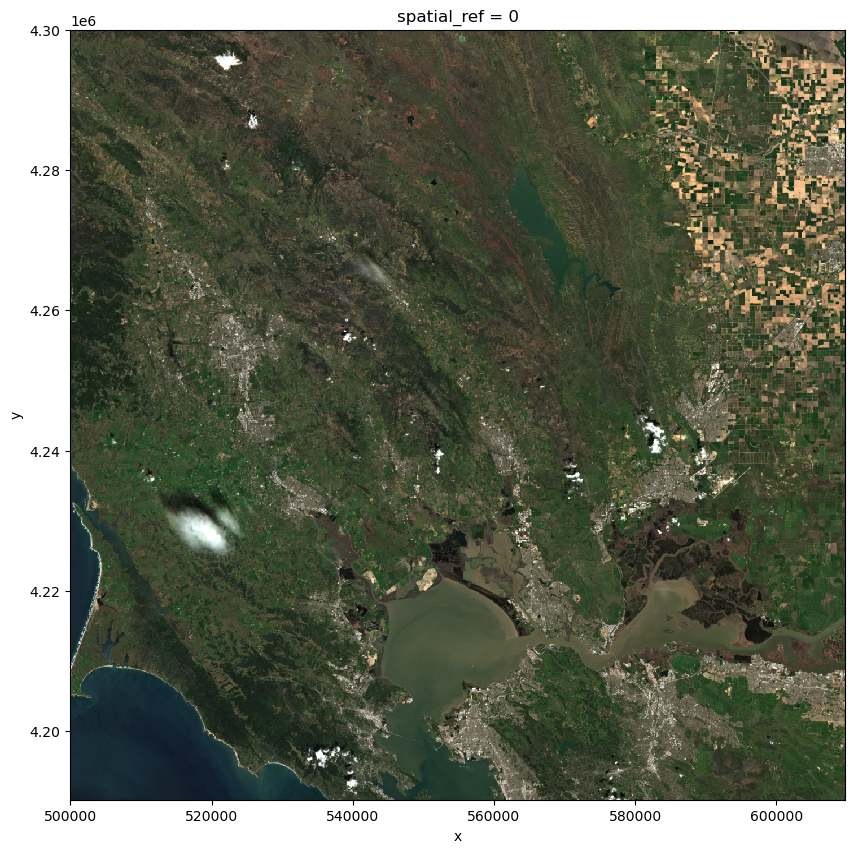

In [10]:
visual.plot.imshow(figsize=(10,10))

## Run Calculation without Dask
Applying a median filter. "The filter is carried out in two steps: first, we define the size and centering of the region around each pixel that will be considered for the median calculation (the so-called “windows”), using the .rolling() method. We choose here windows that are 7 pixel wide in both x and y dimensions, and, for each window, consider the central pixel as the window target. We then call the .median() method, which initiates the construction of the windows and the actual calculation."

In [11]:
%%time
median = visual.rolling(x=7, y=7, center=True).median()

CPU times: user 9.18 s, sys: 2.88 s, total: 12.1 s
Wall time: 13.6 s


/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


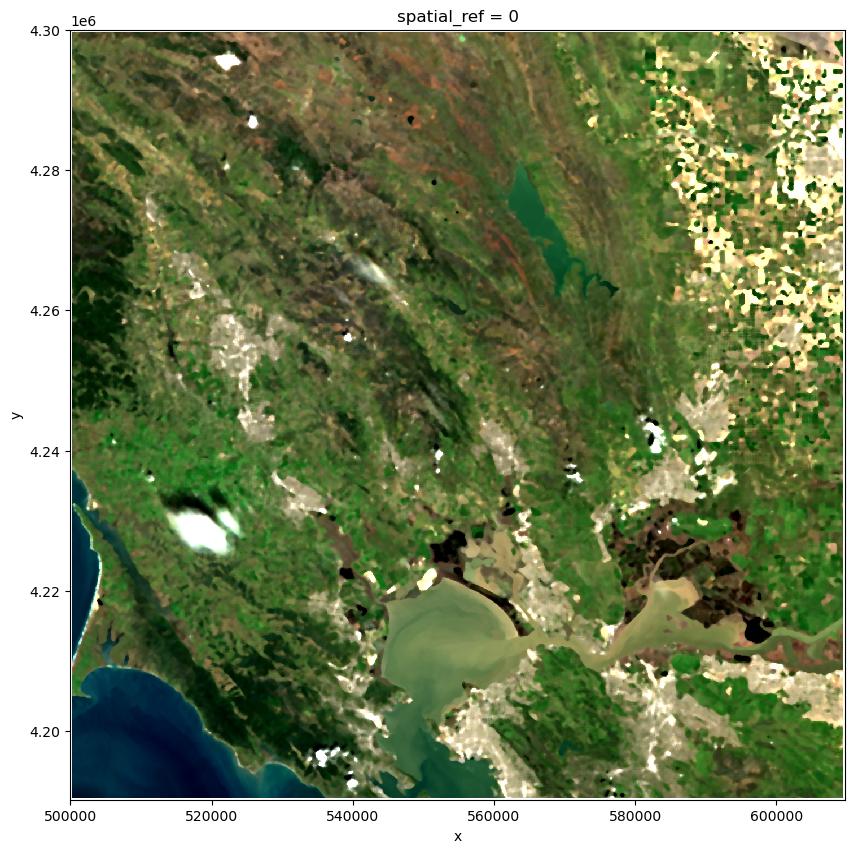

In [12]:
median.plot.imshow(robust=True, figsize=(10,10))

## Dask Rasters

In [14]:
blue_band_href = assets["blue"].href
blue_band = rioxarray.open_rasterio(blue_band_href, chunks=(1, 4000, 4000))
blue_band

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
dask.array<open_rasterio-d2a0baa7823fd1bcd80a9c08ace53621<this-array>, shape=(1, 10980, 10980), dtype=uint16, chunksize=(1, 4000, 4000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
  * y            (y) float64 4.3e+06 4.3e+06 4.3e+06 ... 4.19e+06 4.19e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

We have already seen how COGs are regular GeoTIFF files with a special internal structure. other feature of COGs is that data is organized in “blocks” that can be accessed remotely via independent HTTP requests, abling partial file readings. This is useful if you want to access only a portion of your raster file, but it also lows for efficient parallel reading. You can check the blocksize employed in a COG file with the following code snippet:

In order to optimally access COGs it is best to align the blocksize of the file with the chunks ployed when loading the file. Open the blue-band asset (the “blue” asset) of a Sentinel-2 scene as a chunked DataArray object using a suitable chunk size.

In [17]:
with rasterio.open(visual_href) as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")

Chunk size: [(1024, 1024), (1024, 1024), (1024, 1024)]


Ideal chunk size values for this raster are thus multiples of 1024. An element to consider is number of resulting chunks and their size. While the optimal chunk size strongly depends on the specific application, chunks should in general not be too big nor too small (i.e. too many). As a rule of thumb, chunk sizes of 100 MB typically work well with Dask (see, e.g., this blog post). Also, the shape might be relevant, depending on the application! Here, we might select a chunks shape of (1, 6144, 6144), which would lead to 72MB chunks ((1 x 6144 x 6144) x 2 bytes / 2^20 = 72 MB), or we can just use auto and let dask figure it out for us:

In [19]:
band = rioxarray.open_rasterio(blue_band_href, chunks="auto")

## Parallel Computations

Running the same calculations, but with Dask

In [21]:
visual_dask = rioxarray.open_rasterio(visual_href, overview_level=2, lock=False, chunks=(3, 500, 500))
# Setting lock=False tells rioxarray that the individual data chunks can be loaded simultaneously from the source by the Dask workers.

As the next step, we trigger the download of the data using the `.persist()` method, see below. This makes sure that the downloaded chunks are stored in the form of a chunked Dask array (calling `.load()` would instead merge the chunks in a single Numpy array).

In [22]:
visual_dask = visual_dask.persist(scheduler="threads", num_workers=4)

In [23]:
%%time
median_dask = visual_dask.rolling(x=7, y=7, center=True).median()

CPU times: user 9.32 ms, sys: 1.25 ms, total: 10.6 ms
Wall time: 10.8 ms


This did not run the calculation. Dask arrays are executed "lazily" (they are not immediately run)

In [26]:
%%time
median_dask = median_dask.persist(scheduler="threads", num_workers=4)

CPU times: user 9.39 s, sys: 968 ms, total: 10.4 s
Wall time: 2.85 s


Finally, let’s have a look at how Dask can be used to save raster files. When calling .to_raster(), we provide the following additional arguments: * tiled=True: write raster as a chunked GeoTIFF. * lock=threading.Lock(): the threads which are splitting the workload must “synchronise” when writing to the same file (they might otherwise overwrite each other’s output).

In [27]:
from threading import Lock
median_dask.rio.to_raster("data/visual_median-filter_dask.tif", tiled=True, lock=Lock())